In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import dandelion as ddl
sc.logging.print_header()

warnings.filterwarnings('ignore')
os.chdir('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.4 scipy==1.6.0 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


In [2]:
ddl.logging.print_header()

dandelion==0.1.0 pandas==1.2.3 numpy==1.19.4 matplotlib==3.3.4 networkx==2.5 scipy==1.6.0 skbio==0.5.6


In [4]:
bcells = sc.read_h5ad('h5ad/Bcells_100221.h5ad')
bcells

AnnData object with n_obs × n_vars = 10548 × 33548
    obs: 'sampleid', 'sampleid_study', 'timepoint', 'treatment', 'study_id', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'initial_clustering', 'fine_clustering', 'treatment_timepoint', 'sex', 'age', 'peak_trop', 'BNP', 'on_treatment_CRP', 'AEs', 'treatment_group_1', 'treatment_group_2', 'Lymph', 'CD4', 'CD8', 'Treg', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_heavy', 'locus_light', 'productive_heavy', 'productive_light', 'v_call_genotyped_heavy', 'v_call_genotyped_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light', 'umi_count_heavy_0', 'umi_count_heavy_1', 'umi_count_heavy_2', 'umi_count_heavy_3', 'umi_count_light_0', 'umi_count_light_1', 'umi_count_light_2', 'umi_count_light_

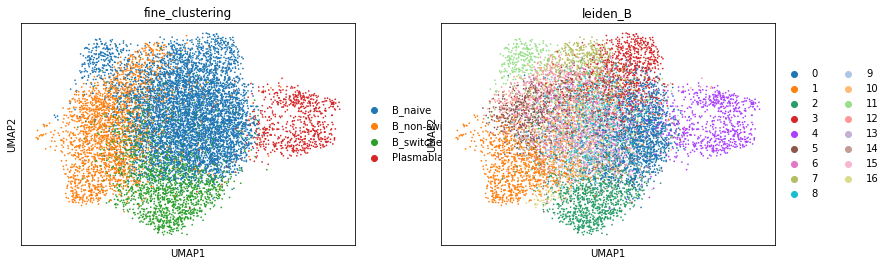

In [5]:
sc.pl.umap(bcells, color = ['fine_clustering', 'leiden_B'])

In [6]:
aki_label = {'0':'B_naive',
'1':'B_non-switched_memory',
'2':'B_switched_memory',
'3':'B_naive',
'4':'Plasmablast',
'5':'B_naive',
'6':'B_naive',
'7':'B_naive',
'8':'B_naive',
'9':'B_naive',
'10':'B_non-switched_memory',
'11':'B_naive',
'12':'B_naive',
'13':'B_naive',
'14':'B_non-switched_memory',
'15':'B_naive',
'16':'B_non-switched_memory'}
bcells.obs['fine_clustering'] = [aki_label[l] for l in bcells.obs['leiden_B']]

... storing 'fine_clustering' as categorical


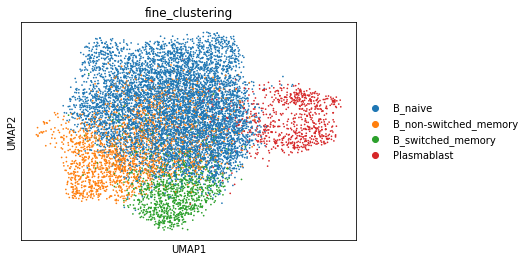

In [7]:
sc.pl.umap(bcells, color = ['fine_clustering'])

### Integrate VDJ using dandelion

In [8]:
# Set up the sample info
sampleInfo = pd.read_csv('../Sample_Key.csv')
sampleInfo['10x_ID'] = ['Sample_Fq'+str(x) for x in sampleInfo['10x_ID']]

In [9]:
sampledict = ddl.utl.dict_from_table(sampleInfo, columns = ('10x_ID', '10x_ID'))

In [10]:
samples = sampleInfo['10x_ID']
df = []
for s in samples:
    df_ = ddl.utl.load_data('../BCR/'+ s + '/dandelion/data/filtered_contig_igblast_gap_genotyped.tsv')
    df.append(df_)
df = df[0].append(df[1:])
df

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,c_germline_alignment,c_sequence_start,c_sequence_end,c_score,c_identity,c_support,sample_id,v_call_genotyped,germline_alignment_d_mask,mu_freq
sequence_id,,,,,,,,,,,,,,,,,,,,,
Sample_Fq1_AAACGGGCACCATCCT-1_contig_1,Sample_Fq1_AAACGGGCACCATCCT-1_contig_1,AGGAGTCAGACCCAGTCAGGACACAGCATGGACATGAGGGTCCCCG...,F,T,"IGKV1-12*01,IGKV1-12*02,IGKV1D-12*02",NaN,IGKJ5*01,GACATCCAGATGACCCAGTCTCCATCTTCCGTGTCTGCATCTGTAG...,GACATCCAGATGACCCAGTCTCCATCTTCCGTGTCTGCATCTGTAG...,TGTCAACAGGCTAAAAGTTTCCCGATCACCTTC,...,CGAACTGTGGCTGCACCATCTGTCTTCATCTTCCCGCCATCTGATG...,415.0,551.0,254.111,100.0,5.000000e-70,Sample_Fq25,"IGKV1-12*01,IGKV1-12*02,IGKV1D-12*02",GACATCCAGATGACCCAGTCTCCATCTTCCGTGTCTGCATCTGTAG...,0.018692
Sample_Fq1_ACACCGGCATCGTCGG-1_contig_1,Sample_Fq1_ACACCGGCATCGTCGG-1_contig_1,AGCTCTGAGAGAGGAGCCCAGCCCTGGGATTTTCAGGTGTTTTCAT...,F,T,"IGHV3-23*01,IGHV3-23D*01",IGHD6-19*01,IGHJ5*02,GAGGTGCAGTTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,GAGGTGCAGCTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,TGTGCGAAAGATCCTGTCCCCGATCACAGTGGCTGGAACTGGTTCG...,...,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,506.0,577.0,134.079,100.0,7.000000e-34,Sample_Fq25,"IGHV3-23*01,IGHV3-23D*01",GAGGTGCAGCTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,0.034884
Sample_Fq1_ACACCGGCATCGTCGG-1_contig_2,Sample_Fq1_ACACCGGCATCGTCGG-1_contig_2,AGAGCTCTGGGGAGGAACTGCTCAGTTAGGACCCAGACGGAACCAT...,F,T,IGKV3-15*01,NaN,IGKJ1*01,GAAATAGTGATGACGCAGTCTCCAGCCACCCTGTCTGTGTCTCCTG...,GAAATAGTGATGACGCAGTCTCCAGCCACCCTGTCTGTGTCTCCAG...,TGTCAGCAGTATAATAACTGGCCTCGGACGTTC,...,GAACTGTGGCTGCACCATCTGTCTTCATCTTCCCGCCATCTGATGA...,427.0,562.0,252.265,100.0,2.000000e-69,Sample_Fq25,IGKV3-15*01,GAAATAGTGATGACGCAGTCTCCAGCCACCCTGTCTGTGTCTCCAG...,0.012461
Sample_Fq1_ACGGCCACAGTTAACC-1_contig_1,Sample_Fq1_ACGGCCACAGTTAACC-1_contig_1,AGAGCTCTGGAGAAGAGCTGCTCAGTTAGGACCCAGAGGGAACCAT...,F,T,IGKV3-20*01,NaN,IGKJ1*01,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,TGTCAGCAGTATGGTAGCTCACCGTGGACGTTC,...,CGAACTGTGGCTGCACCATCTGTCTTCATCTTCCCGCCATCTGATG...,429.0,565.0,254.111,100.0,5.000000e-70,Sample_Fq25,IGKV3-20*01,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,0.000000
Sample_Fq1_ACGGCCACAGTTAACC-1_contig_2,Sample_Fq1_ACGGCCACAGTTAACC-1_contig_2,ACAACCACACCCCTCCTAAGAAGAAGCCCCTAGACCACAGCTCCAC...,F,T,IGHV7-4-1*02,IGHD6-13*01,IGHJ5*02,CAGGTGCAGCTGGTGCAATCTGGGTCT...GAGTTGAAGAAGCCTG...,CAGGTGCAGCTGGTGCAATCTGGGTCT...GAGTTGAAGAAGCCTG...,TGTGCGAGAGAGTATAGCAGCAGCTGGTACGGGGCGTGGGGCTGGT...,...,GCATCCCCGACCAGCCCCAAGGTCTTCCCGCTGAGCCTCTGCAGCA...,479.0,639.0,298.431,100.0,3.000000e-83,Sample_Fq25,IGHV7-4-1*02,CAGGTGCAGCTGGTGCAATCTGGGTCT...GAGTTGAAGAAGCCTG...,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_Fq32_TCACGAAGTTTGCATG-1_contig_2,Sample_Fq32_TCACGAAGTTTGCATG-1_contig_2,TCCAGGCCACGACCAGCTGTTTGGATTTTATAAACGGGCCGTTTGC...,F,T,IGKV4-1*01,NaN,IGKJ1*01,GACATCGTGATGACCCAGTCTCCAGACTCCCTGGCTGTGTCTCTGG...,GACATCGTGATGACCCAGTCTCCAGACTCCCTGGCTGTGTCTCTGG...,TGTCAGCAATATTATAGTACTCCTTGGACGTTC,...,CGAACTGTGGCTGCACCATCTGTCTTCATCTTCCCGCCATCTGATG...,486.0,622.0,254.111,100.0,6.000000e-70,Sample_Fq8,IGKV4-1*01,GACATCGTGATGACCCAGTCTCCAGACTCCCTGGCTGTGTCTCTGG...,0.000000
Sample_Fq32_TCACGAAGTTTGCATG-1_contig_3,Sample_Fq32_TCACGAAGTTTGCATG-1_contig_3,CCAGGGAAGGGGCTGGAGTGGGTTGGCCGTATTAAAAGCAAAACTG...,F,T,"IGHV3-15*01,IGHV3-15*02","IGHD3-16*01,IGHD3-16*02",IGHJ3*02,.................................................,TGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTTGGCCGTA...,TGTACCACAAAGTATTATGATTACGTTTGGGGGAGTTTTGCTTTTG...,...,GCACCCACCAAGGCTCCGGATGTGTTCCCCATCATATCAGGGTGCA...,256.0,358.0,191.325,100.0,3.000000e-51,Sample_Fq8,"IGHV3-15*01,IGHV3-15*02",GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTAAAGCCTG...,0.000000
Sample_Fq32_TGCCCATAGAGCTATA-1_contig_1,Sample_Fq32_TGCCCATAGAGCTATA-1_contig_1,AGGAATCAGACCCAGTCAGGACACAGCATGGACATGAGAGTCCCCG...,F,T,IGKV1-16*01,NaN,IGK

In [11]:
vdj, bcells = ddl.pp.filter_bcr(df, bcells, filter_rna = False)
vdj

Scanning for poor quality/ambiguous contigs with 63 cpus


Annotating in anndata obs slot : 100%|██████████| 10548/10548 [00:00<00:00, 31736.17it/s]


Finishing up filtering
Initializing Dandelion object


Dandelion class object with n_obs = 8448 and n_contigs = 16661
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'junction_aa_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_sup

In [12]:
bcells

AnnData object with n_obs × n_vars = 10548 × 33548
    obs: 'sampleid', 'sampleid_study', 'timepoint', 'treatment', 'study_id', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'initial_clustering', 'fine_clustering', 'treatment_timepoint', 'sex', 'age', 'peak_trop', 'BNP', 'on_treatment_CRP', 'AEs', 'treatment_group_1', 'treatment_group_2', 'Lymph', 'CD4', 'CD8', 'Treg', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_heavy', 'locus_light', 'productive_heavy', 'productive_light', 'v_call_genotyped_heavy', 'v_call_genotyped_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light', 'umi_count_heavy_0', 'umi_count_heavy_1', 'umi_count_heavy_2', 'umi_count_heavy_3', 'umi_count_light_0', 'umi_count_light_1', 'umi_count_light_2', 'umi_count_light_

In [13]:
ddl.tl.find_clones(vdj)

Finding clones based on heavy chains : 100%|██████████| 352/352 [00:00<00:00, 593.40it/s]
Refining clone assignment based on light chain pairing : 100%|██████████| 8448/8448 [00:00<00:00, 495989.36it/s]


In [14]:
ddl.tl.clone_size(vdj)

In [15]:
ddl.tl.clone_size(vdj, max_size=3)

In [16]:
ddl.tl.generate_network(vdj)

Linking edges : 100%|██████████| 8134/8134 [01:03<00:00, 128.84it/s]


generating network layout


In [21]:
ddl.tl.transfer(bcells, vdj, overwrite = True)

converting matrices
Updating anndata slots


In [24]:
bcells

AnnData object with n_obs × n_vars = 10548 × 33548
    obs: 'sampleid', 'sampleid_study', 'timepoint', 'treatment', 'study_id', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'initial_clustering', 'fine_clustering', 'treatment_timepoint', 'sex', 'age', 'peak_trop', 'BNP', 'on_treatment_CRP', 'AEs', 'treatment_group_1', 'treatment_group_2', 'Lymph', 'CD4', 'CD8', 'Treg', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_heavy', 'locus_light', 'productive_heavy', 'productive_light', 'v_call_genotyped_heavy', 'v_call_genotyped_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light', 'umi_count_heavy_0', 'umi_count_heavy_1', 'umi_count_heavy_2', 'umi_count_heavy_3', 'umi_count_light_0', 'umi_count_light_1', 'umi_count_light_2', 'umi_count_light_

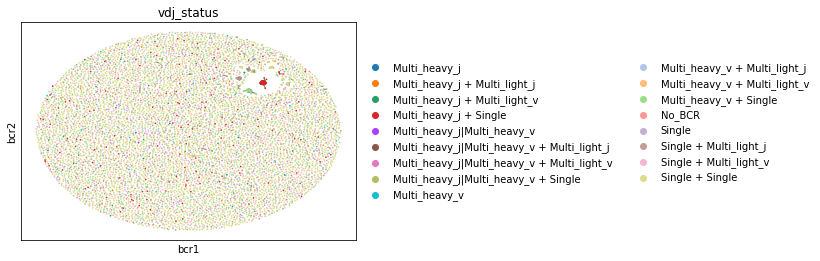

In [26]:
ddl.pl.clone_network(bcells, color = 'vdj_status', edges_width = 1)

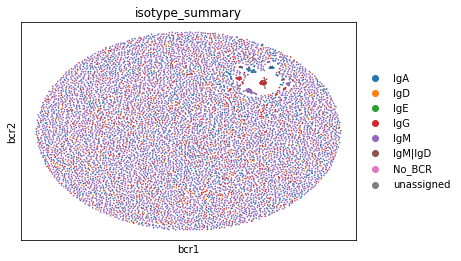

In [25]:
ddl.pl.clone_network(bcells, color = 'isotype_summary', edges_width = 1)

In [29]:
# read in sample information
design_df = pd.read_csv('../sampleinfo.txt', sep = '\t')
design_df.set_index('sampleid', inplace = True)
design_df

,study_id,timepoint,sex,age,treatment,peak_trop,BNP,on_treatment_CRP,AEs,treatment_group_1,treatment_group_2,Lymph,CD4,CD8,Treg
sampleid,,,,,,,,,,,,,,,
Sample_Fq1,L6010,pre,male,61,Saline,999,75,9.00,0,untreated,untreated,1.25500,0.352000,0.163000,0.026
Sample_Fq2,L6010,post,male,61,Saline,999,75,1.50,0,untreated,untreated,1.06800,0.438000,0.171000,0.038
Sample_Fq3,L6009,pre,male,70,1.5MIU,1790,141,0.10,0,untreated,untreated,1.46900,0.646000,0.441000,0.054
Sample_Fq4,L6009,post,male,70,1.5MIU,1790,141,5.20,0,1.5MIU,treated,1.14900,0.620000,0.287000,0.108
Sample_Fq5,L6008,pre,female,66,1.5MIU,4255,630,5.00,1,untreated,untreated,1.07900,0.507000,0.356000,0.036
Sample_Fq6,L6008,post,female,66,1.5MIU,4255,630,30.00,1,1.5MIU,treated,1.32000,0.779000,0.370000,0.066
Sample_Fq7,L6007,pre,female,57,1.5MIU,2067,85,0.70,0,untreated,untreated,1.87200,0.393000,1.067000,0.025
Sample_Fq8,L6007,post,female,57,1.5MIU,2067,85,8.20,0,1.5MIU,treated,1.20700,0.290000,0.628000,0.032
Sample_Fq9,L6006,pre,male,59,1.5MIU,102,90,1.60,0,untreated,untreated,2.43000,1.094000,0.583000,0.115


In [30]:
bcells.obs['sampleid'] = [x.rsplit('_',1)[0] for x in bcells.obs_names]

In [31]:
for x in design_df.columns:
    bcells.obs[x] = [design_df[x].to_dict()[s] for s in bcells.obs['sampleid']]

In [32]:
bcells.obs

,sampleid,sampleid_study,timepoint,treatment,study_id,scrublet_score,n_genes,percent_mito,n_counts,is_doublet,...,productive_summary,isotype,isotype_summary,vdj_status_detail,vdj_status,clone_id_size,clone_id_size_max_3,leiden_B,vdj_status_summary,heavychain_status_summary
Sample_Fq1_AACTCCCAGTACGACG,Sample_Fq1,L6010T2,pre,Saline,L6010,0.053861,706,3.220730,1777.167483,False,...,T + T,IgM,IgM,No_BCR,Single + Multi_light_v,1.0,1,8,Single,Single
Sample_Fq1_AAGGAGCGTGTCCTCT,Sample_Fq1,L6010T2,pre,Saline,L6010,0.055118,614,1.914605,1439.984258,False,...,T + T,IgM,IgM,Single + Single,Single + Single,1.0,1,15,Single,Single
Sample_Fq1_AATCCAGCACCAGGTC,Sample_Fq1,L6010T2,pre,Saline,L6010,0.028000,990,2.760000,3219.388714,False,...,T + T,IgM,IgM,Single + Multi_light_v,Single + Multi_light_v,1.0,1,4,Single,Single
Sample_Fq1_AATCCAGGTCGGATCC,Sample_Fq1,L6010T2,pre,Saline,L6010,0.030272,994,7.225631,2796.707745,False,...,No_BCR,No_BCR,No_BCR,No_BCR,No_BCR,NaN,NaN,16,No_BCR,No_BCR
Sample_Fq1_ACAGCTACAGGCTGAA,Sample_Fq1,L6010T2,pre,Saline,L6010,0.044723,972,2.174665,2681.497028,False,...,No_BCR,No_BCR,No_BCR,No_BCR,No_BCR,NaN,NaN,10,No_BCR,No_BCR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_Fq32_TTAGGCATCATACGGT,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.093248,536,8.025645,1042.916962,False,...,T + T,IgM,IgM,Single + Single,Single + Single,1.0,1,8,Single,Single
Sample_Fq32_TTCCCAGTCATGTCCC,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.057283,610,7.274370,1540.755722,False,...,T + T,IgM,IgM,Multi_heavy_v + Multi_light_v,Multi_heavy_v + Multi_light_v,1.0,1,16,Multi,Single
Sample_Fq32_TTGCCGTCAGTACACT,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.033010,782,4.001608,1888.792406,False,...,T + T,IgM,IgM,Multi_heavy_v + Single,Single + Single,1.0,1,3,Single,Single
Sample_Fq32_TTGCGTCCAAGGGTCA,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.102041,539,3.466898,1086.907490,False,...,T + T,IgM,IgM,Single + Multi_light_v,Single + Multi_light_v,1.0,1,3,Single,Single


In [33]:
bcells.write('h5ad/Bcells_230321.h5ad', compression = 'gzip')

... storing 'sampleid' as categorical
... storing 'timepoint' as categorical
... storing 'treatment' as categorical
... storing 'study_id' as categorical
... storing 'sex' as categorical
... storing 'treatment_group_1' as categorical
... storing 'treatment_group_2' as categorical


In [34]:
bcells.obs.to_csv('h5ad/corrected_Bcells_metadata.csv')

In [ ]:
## Update main object(s)

In [39]:
rna = sc.read_h5ad('h5ad/adata_soupx_trans_cite_rna.h5ad')
adata = sc.read_h5ad('h5ad/adata_soupx_trans_cite_raw.h5ad')
adata2 = sc.read_h5ad('h5ad/adata_soupx_trans_raw.h5ad')
adata3 = sc.read_h5ad('h5ad/adata_soupx_trans_cite_bgshift_raw.h5ad')

In [40]:
bcells.obs['fine_clustering'] = bcells.obs['fine_clustering'].astype('object')
rna.obs['fine_clustering'] = rna.obs['fine_clustering'].astype('object')
rna.obs['fine_clustering'].update(bcells.obs['fine_clustering'])

In [41]:
adata.obs = rna.obs.copy()
adata2.obs = rna.obs.copy()
adata3.obs = rna.obs.copy()

In [42]:
rna.obs

,sampleid,sampleid_study,timepoint,treatment,study_id,scrublet_score,n_genes,percent_mito,n_counts,is_doublet,...,BNP,on_treatment_CRP,AEs,treatment_group_1,treatment_group_2,Lymph,CD4,CD8,Treg,sample_id
Sample_Fq1_AAACCTGAGATTACCC,Sample_Fq1,L6010T2,pre,Saline,L6010,0.053861,870,2.876169,1941.831651,False,...,75,9.0,0,untreated,untreated,1.255,0.35200,0.16300,0.026,Sample_Fq1
Sample_Fq1_AAACCTGAGCCCAATT,Sample_Fq1,L6010T2,pre,Saline,L6010,0.128095,1031,5.500396,2031.293912,False,...,75,9.0,0,untreated,untreated,1.255,0.35200,0.16300,0.026,Sample_Fq1
Sample_Fq1_AAACCTGAGGGTCTCC,Sample_Fq1,L6010T2,pre,Saline,L6010,0.023124,576,1.723816,1485.500157,False,...,75,9.0,0,untreated,untreated,1.255,0.35200,0.16300,0.026,Sample_Fq1
Sample_Fq1_AAACCTGAGGTGCTAG,Sample_Fq1,L6010T2,pre,Saline,L6010,0.060440,991,1.640358,2419.141384,False,...,75,9.0,0,untreated,untreated,1.255,0.35200,0.16300,0.026,Sample_Fq1
Sample_Fq1_AAACCTGCAAGCCTAT,Sample_Fq1,L6010T2,pre,Saline,L6010,0.104225,839,3.271511,1538.276287,False,...,75,9.0,0,untreated,untreated,1.255,0.35200,0.16300,0.026,Sample_Fq1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_Fq32_TTTGTCAGTGTCCTCT,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.010219,548,6.286075,1263.726819,False,...,936,19.7,1,2.5MIU,treated,1.131,0.52026,0.24882,0.072,Sample_Fq32
Sample_Fq32_TTTGTCAGTTACAGAA,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.090526,825,4.654680,1595.441862,False,...,936,19.7,1,2.5MIU,treated,1.131,0.52026,0.24882,0.072,Sample_Fq32
Sample_Fq32_TTTGTCATCCTAGAAC,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.123077,2134,3.495720,6932.107353,False,...,936,19.7,1,2.5MIU,treated,1.131,0.52026,0.24882,0.072,Sample_Fq32
Sample_Fq32_TTTGTCATCGTGGACC,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.064125,1152,4.524075,2839.560090,False,...,936,19.7,1,2.5MIU,treated,1.131,0.52026,0.24882,0.072,Sample_Fq32


In [43]:
# save first
rna.write('h5ad/adata_soupx_trans_cite_rna.h5ad', compression = 'gzip')
adata.write('h5ad/adata_soupx_trans_cite_raw.h5ad', compression = 'gzip')
adata2.write('h5ad/adata_soupx_trans_raw.h5ad', compression = 'gzip')
adata3.write('h5ad/adata_soupx_trans_cite_bgshift_raw.h5ad', compression = 'gzip')

... storing 'fine_clustering' as categorical
... storing 'fine_clustering' as categorical
... storing 'fine_clustering' as categorical
... storing 'fine_clustering' as categorical
